# Plan for analysis

Note: for ACL, what is mostly relevant is point 3. Focusing on that for the moment.

1. Name adequacy:
 - distribution of adequacy of all names (all data, not per image). **DONE**
 - proportion of names/image that are adequate (boxplot?). Needs adequacy threshold (I used > 0.5 below). 
 
2. Region ambiguity:
 - distribution of number of clusters per image (how many images have 1, 2, ... n clusters). Barplot (ordinal variable). 
 - distribution of response frequency per cluster (percentage of responses in cluster 0, 1, ... m). Boxplots? Or barplot with standard deviation bars?
 - distribution of total name frequency for canonical object (proportion of responses that go to the most frequent object, that is, cluster 0). (Expectation: mostly very high). 
 - analyze which cases are errors, which are bounding box ambiguity. 

==> estimate the n of images for which we have enough naming data (something like at least x adequate names for cluster 0?). 

3. For canonical object (cluster 0):
 - distribution of raw number of adequate names (needs threshold to determining whether name is adequate; using > 0.5).  **DONE** 
     ==> Problem: not all canonical objects have same number of adequate names. Make number of adequate names relative? (TODO)
 - distribution of the frequency of the entry-level name in the canonical object.  **DONE**
 - how often the entry-level name coincides with the VG name (see if it's very different from the number we obtained before verification phase). **DONE**
 
4. (Do something with remaining clusters with adequate names, and other types of analyses)

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval
from collections import Counter

In [3]:
df=pd.read_csv('../proc_data_phase0/verification/all_responses_round0-3_verified.csv', sep="\t")
df=df.drop(['responses_r0','opt-outs','top_response_domain_r0','responses_domains_r0',
            'sample_type','all_responses','clean','canon','spellchecked',
            'responses_domains_r1', 'responses_r1', 'top_response_domain_r1',
       'responses_domains_r2', 'responses_r2', 'top_response_domain_r2',
       'responses_domains_r3', 'responses_r3', 'top_response_domain_r3'], axis=1)
df.head()
total_objects=len(df)

In [4]:
# get necessary data from csv file

adequacies=[] # number of adequate names (total)
tot_names=0; tot_ad=0 # total n of names; n of -adequate names (see threshold below)
list_n_ad_names=[] # number of adequate names per canonical object
list_entry_names=[] # entry names for each canonical object (cluster 0)
list_freqs_entry_name=[] # entry names for each canonical object (cluster 0)
no_entry_lev=0
for row in df.itertuples():
    name_freqs=eval(row.spellchecked_min2)
    #print(name_freqs)
    # find entry-level name; this should be done for the canonical object,
    # but I can't recover the info from the verified column (name data in a dictionary),
    # so I use the one from all data and check if the entry level name form those data is in cluster 0
    # there are only 700 imgs where the most frequent name is not in cluster 0; TODO: check them, and mend this
    entry_name,entry_freq=name_freqs.most_common(1)[0] # returns tuple, e.g. ('man',11)
    d = literal_eval(row.verified) # dictionary with verification data
    n_ad_names_img=0; freqs_canon_names=1; entry_name_in_cluster0=False
    for name in d.keys(): # each name for this object
        tot_names+=1
        #print("\t",name)
        values_dict = d[name]
        ad=values_dict['adequacy']
        adequacies.append(ad); 
        if ad > 0.5: tot_ad += 1
        else: # name is adequate
            if values_dict['cluster_id']==0: # labels canonical object
                if name==entry_name: entry_name_in_cluster0=True
                n_ad_names_img += 1 # number of adequate names
                freqs_canon_names += name_freqs[name] # total frequency of canonical names
#    print("\t",freqs_canon_names)
    if entry_name_in_cluster0==False: entry_name,entry_freq=(None,0) ### TO BE MENDED IN THE FUTURE (see comment 'find entry-level name' above)
    list_n_ad_names.append(n_ad_names_img)
    list_entry_names.append(entry_name)
    freq_entry_name=(entry_freq+1)/freqs_canon_names
    list_freqs_entry_name.append(freq_entry_name)

df['n_canonical_names']=list_n_ad_names
df['entry_name']=list_entry_names
df['entry_freq']=list_freqs_entry_name


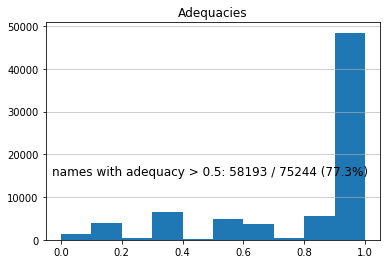

In [5]:
# Histogram for name adequacies
adequacies=np.array(adequacies)
plt.hist(x=adequacies)
plt.grid(axis='y', alpha=0.75)
plt.title('Adequacies')
to_write='names with adequacy > 0.5: {} / {} ({:.1%})'.format(tot_ad, tot_names, tot_ad/tot_names)
plt.text(-0.03,15000,to_write,fontsize='large')
plt.show()
plt.close()

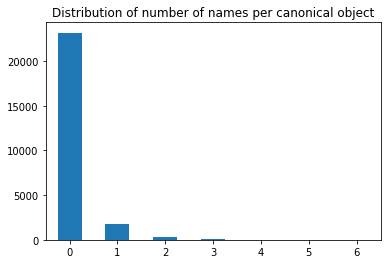

In [6]:
ndist = df.n_canonical_names.value_counts()
ndist.plot(kind='bar',rot=0,title="Distribution of number of names per canonical object")
plt.show()
plt.close()

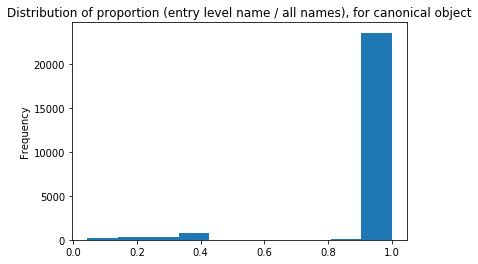

canonical objects for which proportion > 0.5: 93.5%


In [7]:
df.entry_freq.plot(kind='hist',title="Distribution of proportion (entry level name / all names), for canonical object")
plt.show()
plt.close()
t=len(df[df.entry_freq > 0.5])
to_write='canonical objects for which proportion > 0.5: {:.1%}'.format(t/total_objects)
#plt.text(0,6000,to_write,fontsize='large') # gives me trouble
print(to_write)

In [8]:
mismatch=len(df[df.entry_name == df.vg_obj_name])
print('Objects for which manynames entry level name coincides with VG name: {} ({:.1%})'.format(mismatch, mismatch/total_objects))
# slightly lower; could be due to the 700 cases that were assigned 'None' above?

Objects for which manynames entry level name coincides with VG name: 96 (0.4%)
